<h1 style="text-align: center; font-size: 50px;"> 🤖 MLFlow Registration for Multimodal RAG</h1>

# MLFlow Model Service 

In this section, we demonstrate how to deploy a RAG-based chatbot service. This service provides a REST API endpoint that allows users to query the knowledge base with natural language questions, upload new documents to the knowledge base, and manage conversation history, all with built-in safeguards against sensitive information and toxicity. This service encapsulates all the functionality we developed in this notebook, including the document retrieval system, RAG-based question answering capabilities, and MLFlow integration for observation and evaluation. It demonstrates how to use our ChatbotService from the src/service directory. 

## Step 0: Imports and Environment Setup

In [1]:
import time
import os 
from pathlib import Path
import sys
import logging

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Create logger
logger = logging.getLogger("multimodal_rag_logger")
logger.setLevel(logging.INFO)
if not logger.handlers:
    formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S")
    stream_handler = logging.StreamHandler(sys.stdout)
    stream_handler.setFormatter(formatter)
    logger.addHandler(stream_handler)
logger.propagate = False

In [2]:
start_time = time.time()  

logger.info("Notebook execution started.")

2025-07-30 14:16:01 - INFO - Notebook execution started.


In [3]:
%pip install -r ../requirements.txt --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
galileo-protect 0.15.1 requires galileo-core<3.0.0,>=2.17.0, but you have galileo-core 3.60.0 which is incompatible.
galileo-observe 1.13.2 requires galileo-core<3.0.0,>=2.20.0, but you have galileo-core 3.60.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [4]:
# === Standard Library Imports ===
import gc
import json
import math
import os
import base64
import tempfile
import shutil
import warnings
from rank_bm25 import BM25Okapi
from typing import Any, Dict, List, Optional, TypedDict
from statistics import mean
from collections import defaultdict
import hashlib
from IPython.display import display, Image, Markdown

# === Third-Party Library Imports ===
import mlflow
import numpy as np
import pandas as pd
import torch
from langchain_core.embeddings import Embeddings
from langchain.schema.document import Document
from langchain.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter, MarkdownHeaderTextSplitter
from mlflow.models.signature import ModelSignature
from mlflow.tracking import MlflowClient
from mlflow.types import ColSpec, DataType, Schema, TensorSpec
from PIL import Image as PILImage
from sentence_transformers import CrossEncoder, SentenceTransformer
from transformers import pipeline, AutoImageProcessor, AutoModel, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, SiglipModel, SiglipProcessor

# === Project-Specific Imports ===
# Add the project root to the system path to allow importing from 'src'
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.components import SemanticCache, SiglipEmbeddings
from src.wiki_pages_clone import orchestrate_wiki_clone
from src.local_genai_judge import LocalGenAIJudge
from src.utils import (
    configure_hf_cache,
    multimodal_rag_asset_status,
    load_config,
    load_secrets,
    load_mm_docs_clean,
)

2025-07-30 14:17:07.473825: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-30 14:17:07.483096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753885027.494013     264 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753885027.497459     264 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753885027.506615     264 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [5]:
warnings.filterwarnings("ignore")

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")

Using device: cuda


## Step 1: Configurations

### Verify Assets

In [7]:
CONFIG_PATH = "../configs/config.yaml"
SECRETS_PATH = "../configs/secrets.yaml"

LOCAL_MODEL = "/home/jovyan/datafabric/InternVL3-8B-Instruct"
CONTEXT_DIR: Path = Path("../data/context")
CHROMA_DIR: Path = Path("../data/chroma_store")     
CACHE_DIR: Path = CHROMA_DIR / "semantic_cache"
MANIFEST_PATH: Path = CHROMA_DIR / "manifest.json"

IMAGE_DIR = CONTEXT_DIR / "images"
WIKI_METADATA_DIR = CONTEXT_DIR / "wiki_flat_structure.json"

CHROMA_DIR.mkdir(parents=True, exist_ok=True)
CACHE_DIR.mkdir(parents=True, exist_ok=True)

multimodal_rag_asset_status(
    local_model_path=LOCAL_MODEL,
    config_path=CONFIG_PATH,
    secrets_path=SECRETS_PATH,
    wiki_metadata_dir=WIKI_METADATA_DIR,
    context_dir=CONTEXT_DIR,
    chroma_dir=CHROMA_DIR,
    cache_dir=CACHE_DIR,
    manifest_path=MANIFEST_PATH
)

2025-07-30 14:17:09 - INFO - Local Model is properly configured. 
2025-07-30 14:17:09 - INFO - Config is properly configured. 
2025-07-30 14:17:09 - INFO - Secrets is properly configured. 
2025-07-30 14:17:09 - INFO - wiki_flat_structure.json is properly configured. 
2025-07-30 14:17:09 - INFO - CONTEXT is properly configured. 
2025-07-30 14:17:09 - INFO - CHROMA is properly configured. 
2025-07-30 14:17:09 - INFO - CACHE is properly configured. 
2025-07-30 14:17:09 - INFO - MANIFEST is properly configured. 


In [8]:
config = load_config(CONFIG_PATH)

### Config HuggingFace Caches

In the next cell, we configure HuggingFace cache, so that all the models downloaded from them are persisted locally, even after the workspace is closed. This is a future desired feature for AI Studio and the GenAI addon.

In [9]:
configure_hf_cache()

In [10]:
# Initialize HuggingFace Embeddings
txt_embeddings = HuggingFaceEmbeddings(
    model_name="intfloat/e5-large-v2",
    cache_folder="/tmp/hf_cache"
)

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

### MLflow Configuration

In [11]:
MODEL_NAME = "AIStudio-Multimodal-Chatbot-Model"
RUN_NAME = f"Register_{MODEL_NAME}"
EXPERIMENT_NAME = "AIStudio-Multimodal-Chatbot-Experiment"

# Set MLflow tracking URI and experiment
# This should be configured for your environment, e.g., a remote server or local file path
mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI", "/phoenix/mlflow"))
mlflow.set_experiment(experiment_name=EXPERIMENT_NAME)

logger.info(f"Using MLflow tracking URI: {mlflow.get_tracking_uri()}")
logger.info(f"Using MLflow experiment: '{EXPERIMENT_NAME}'")

2025-07-30 14:17:45 - INFO - Using MLflow tracking URI: /phoenix/mlflow
2025-07-30 14:17:45 - INFO - Using MLflow experiment: 'AIStudio-Multimodal-Chatbot-Experiment'


## Step 2: MLflow Model Setup

In [12]:

class MultimodalRagModel(mlflow.pyfunc.PythonModel):
    """
    An MLflow PythonModel for a dynamic, updatable Multimodal RAG pipeline.

    This model acts as a service with multiple commands:
    - 'update_kb': Fetches the latest data from a source (e.g., ADO Wiki),
      incrementally updates the vector knowledge base, and clears the cache.
    - 'query': Answers a user's question using the RAG pipeline, with
      built-in semantic caching and self-evaluation.

    The knowledge base (ChromaDB) and semantic cache are managed dynamically
    on the server's persistent storage, not as static model artifacts.
    """

    # ==========================================================================
    # 1. Inner Class for the RAG Generation Pipeline
    # This is your original logic, kept intact. It's the "engine" of our service.
    # ==========================================================================
    class InternVLMM:
        """Minimal, self-contained multimodal QA wrapper around InternVL3-8B-Instruct."""
        def __init__(self, model_path: str, device: str, cache: Any, text_db: Chroma, image_db: Chroma, bm25_index: BM25Okapi, doc_map: dict):
            self.model_path = str(model_path)
            self.device = device
            self.model = None
            self.tok = None
            self.image_processor = None
            self.cache = cache
            self.text_db = text_db
            self.image_db = image_db
            self.bm25_index = bm25_index
            self.doc_map = doc_map
            self._load()

        @staticmethod
        def _reciprocal_rank_fusion(results: list[list[Document]], k: int = 60) -> list[tuple[Document, float]]:
            ranked_lists = [
                {doc.page_content: (doc, i + 1) for i, doc in enumerate(res)}
                for res in results
            ]
            rrf_scores = defaultdict(float)
            all_docs = {}
            for ranked_list in ranked_lists:
                for content, (doc, rank) in ranked_list.items():
                    rrf_scores[content] += 1 / (k + rank)
                    if content not in all_docs:
                        all_docs[content] = doc
            fused_results = [
                (all_docs[content], rrf_scores[content])
                for content in sorted(rrf_scores, key=rrf_scores.get, reverse=True)
            ]
            return fused_results

        def _retrieve_mm(self, query: str, k_text: int = 3, k_img: int = 4, recall_k: int = 20) -> dict[str, any]:
            dense_hits = self.text_db.similarity_search(query, k=recall_k)
            tokenized_query = query.lower().split(" ")
            sparse_texts = self.bm25_index.get_top_n(tokenized_query, list(self.doc_map.keys()), n=recall_k)
            sparse_hits = [self.doc_map[text] for text in sparse_texts]

            if not dense_hits and not sparse_hits:
                return {"docs": [], "scores": [], "images": []}

            fused_results = self._reciprocal_rank_fusion([dense_hits, sparse_hits])
            final_docs = [doc for doc, score in fused_results[:k_text]]
            final_scores = [score for doc, score in fused_results[:k_text]]

            retrieved_images = []
            if final_docs:
                final_sources = list(set(d.metadata["source"] for d in final_docs))
                image_hits = self.image_db.similarity_search(query, k=k_img, filter={"source": {"$in": final_sources}})
                retrieved_images = [img.page_content for img in image_hits]

            return {"docs": final_docs, "scores": final_scores, "images": retrieved_images}

        def generate(self, query: str, force_regenerate: bool = False, **retrieval_kwargs) -> Dict[str, Any]:
            start_gen_time = time.time()
            
            if not force_regenerate and self.cache:
                cached_result = self.cache.get(query, threshold=0.92)
                if cached_result:
                    logger.info(f"SEMANTIC CACHE HIT for query: '{query}'")
                    if "generation_time_seconds" not in cached_result:
                        cached_result["generation_time_seconds"] = 0.0
                    return cached_result
            
            if force_regenerate and self.cache:
                logger.info(f"Forced regeneration for query: '{query}'. Clearing old cache entry.")
                self.cache.delete(query)
            
            logger.info(f"CACHE MISS for query: '{query}'. Running full pipeline.")
            if self.model is None or self.tok is None:
                return {"reply": "Error: model not initialised.", "used_images": [], "generation_time_seconds": 0.0}

            hits = self._retrieve_mm(query, **retrieval_kwargs)
            docs, images = hits["docs"], hits["images"]
            if not docs and not images:
                return {"reply": "Based on the provided context, I cannot answer this question.", "used_images": [], "generation_time_seconds": 0.0}

            context_str = "\n\n".join(
                f"<source_document name=\"{d.metadata.get('source', 'unknown')}\">\n{d.page_content}\n</source_document>"
                for d in docs
            )
            system_prompt = """You are an AI Studio Expert Assistant. Your task is to answer the user's query based ONLY on the context provided. 
            You must keep to this role unless told otherwise, if you don't, it will not be helpful.
            
                **Instructions:**
                1.  **Analyze Context:** First, analyze the user's images (if any) and the text in the `<context>` block.
                2.  **Synthesize Answer:** Answer the user's query directly, synthesizing information from the context.
                3.  **Cite Sources:** List all source documents you used in a `Source Documents` section.
                4.  **Handle Missing Information:** If the answer is not in the context, respond with this exact phrase: "Based on the provided context, I cannot answer this question."
                5.  **Do not Hallucinate:** Do not hallucinate or make up factual information.
                
                **Output Format:**
                Your response must follow this exact markdown structure and nothing else. Do not add any other commentary.
                
                ### Visual Analysis
                (Analyze the user's images here.)
                
                ### Synthesized Answer
                (Your answer to the user's query goes here.)
                
                ### Source Documents
                (List the sources here, like [`source-file-name.md`].)
                """
            user_content = f"""<context>
            {context_str}
            </context>
            
            <user_query>
            {query}
            </user_query>
            """
            conversation = [{"role": "system", "content": system_prompt}, {"role": "user", "content": user_content}]
            prompt = self.tok.apply_chat_template(conversation, tokenize=False, add_generation_prompt=True)

            try:
                self._clear_cuda()
                pixel_values = self._process_images(images) if images else None
                reply = self.model.chat(
                    self.tok, pixel_values, prompt,
                    generation_config=dict(
                        do_sample=False,
                        max_new_tokens=1024, 
                        repetition_penalty=1.1,
                        pad_token_id=self.tok.pad_token_id, eos_token_id=self.tok.eos_token_id,
                    ),
                )
                self._clear_cuda()
                end_gen_time = time.time()
                result_dict = {"reply": reply, "used_images": images, "generation_time_seconds": end_gen_time - start_gen_time}
                
                if self.cache:
                    self.cache.set(query, result_dict)
                
                return result_dict
            except RuntimeError as e:
                logger.error("InternVL generation failed: %s", e)
                return {"reply": f"Error during generation: {e}", "used_images": images, "generation_time_seconds": 0.0}

        def _load(self):
            logger.info("Loading %s...", self.model_path)
            self._clear_cuda()
            self.tok = AutoTokenizer.from_pretrained(self.model_path, trust_remote_code=True)
            if self.tok.pad_token is None: self.tok.pad_token = self.tok.eos_token
            self.image_processor = AutoImageProcessor.from_pretrained(self.model_path, trust_remote_code=True, use_fast=True)
            q_cfg = BitsAndBytesConfig(
                load_in_4bit=True, bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=torch.bfloat16, bnb_4bit_use_double_quant=True,
            ) if self.device == "cuda" else None
            self.model = AutoModel.from_pretrained(
                self.model_path, quantization_config=q_cfg,
                torch_dtype=(torch.bfloat16 if self.device == "cuda" else torch.float32),
                low_cpu_mem_usage=True, use_flash_attn=False, trust_remote_code=True,
                device_map="auto" if self.device == "cuda" else None,
            ).eval()
            logger.info("Model loaded on %s.", self.device)

        def _process_images(self, image_paths: List[str]):
            if not image_paths: return None
            try:
                pil_images = [PILImage.open(p).convert("RGB") for p in image_paths]
                processed_data = self.image_processor(images=pil_images, return_tensors="pt")
                pixel_values = processed_data['pixel_values'].to(device=self.device, dtype=next(self.model.parameters()).dtype)
                return pixel_values
            except Exception as e:
                logger.error("Image processing failed: %s", e)
                return None

        def _clear_cuda(self):
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                torch.cuda.synchronize()

    # ==========================================================================
    # 2. MLflow `pyfunc` Life-cycle and Service Methods
    # ==========================================================================
    def load_context(self, context: mlflow.pyfunc.PythonModelContext) -> None:
        logger.info("--- Initializing Dynamic MultimodalRAG Service ---")
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        self.persistent_storage_path = Path("/tmp/multimodal_rag_service_data")
        
        self.persistent_storage_path.mkdir(parents=True, exist_ok=True)
        self.chroma_store_path = self.persistent_storage_path / "chroma_store"
        self.cache_dir = self.persistent_storage_path / "semantic_cache"
        self.manifest_path = self.persistent_storage_path / "manifest.json"
        
        logger.info(f"Service data will be managed at: {self.persistent_storage_path}")

        self.model_path = Path(context.artifacts["local_model_dir"]).resolve()
        e5_model_path = context.artifacts["e5_model_dir"]
        siglip_model_path = context.artifacts["siglip_model_dir"]
        
        self.text_embed_model = HuggingFaceEmbeddings(model_name=e5_model_path, model_kwargs={"device": self.device})
        self.siglip_embed_model = SiglipEmbeddings(model_id=siglip_model_path, device=self.device)

        self.text_db = None
        self.image_db = None
        self.bm25_index = None
        self.doc_map = None
        self.cache = None
        self.mm_llm = None
        self.judge = None

        logger.info("--- Service initialized. Ready to receive commands. ---")

    def predict(self, context: mlflow.pyfunc.PythonModelContext, model_input: pd.DataFrame) -> pd.DataFrame:
        command = model_input["command"].iloc[0]
        logger.info(f"Received command: '{command}'")
        
        if command == "update_kb":
            payload = json.loads(model_input["payload"].iloc[0])
            result = self.update_knowledge_base(config=payload["config"], secrets=payload["secrets"])
            return pd.DataFrame([result])
    
        elif command == "query":
            if self.mm_llm is None:
                logger.info("First query received. Initializing RAG pipeline from persistent storage...")
                self._initialize_rag_pipeline()
            
            query = model_input["query"].iloc[0]
            force_regenerate = model_input.get("force_regenerate", pd.Series([False])).iloc[0]
            
            response_dict = self.mm_llm.generate(query, force_regenerate=force_regenerate)
            
            # --- Convert image paths to Base64 strings ---
            image_paths = response_dict.get("used_images", [])
            base64_images = []
            if image_paths:
                for path in image_paths:
                    try:
                        with open(path, "rb") as img_file:
                            encoded_string = base64.b64encode(img_file.read()).decode('utf-8')
                            base64_images.append(encoded_string)
                    except FileNotFoundError:
                        logger.warning(f"Image file not found at path during encoding: {path}")
            
            # Replace the path list with a JSON string of Base64 images
            response_dict["used_images"] = json.dumps(base64_images)
    
            if self.judge:
                retrieved_info = self.mm_llm._retrieve_mm(query)
                context_str = "\n\n".join(d.page_content for d in retrieved_info["docs"])
                eval_df = pd.DataFrame([{"questions": query, "result": response_dict["reply"], "source_documents": context_str}])
                response_dict["faithfulness"] = self.judge.evaluate_faithfulness(eval_df).iloc[0]
                response_dict["relevance"] = self.judge.evaluate_relevance(eval_df).iloc[0]
            else:
                response_dict["faithfulness"], response_dict["relevance"] = None, None
            
            return pd.DataFrame([response_dict])
    
        else:
            return pd.DataFrame([{"status": "error", "message": f"Unknown command: {command}"}])

    def update_knowledge_base(self, config: dict, secrets: dict) -> dict:
        logger.info("Starting knowledge base update...")
        
        # --- FIX: Use a permanent directory for processed data, not a temporary one ---
        processed_data_dir = self.persistent_storage_path / "processed_data"
        processed_data_dir.mkdir(parents=True, exist_ok=True)
    
        try:
            # Step 1: Fetch latest data directly into the permanent processed data directory
            orchestrate_wiki_clone(pat=secrets['AIS_ADO_TOKEN'], config=config, output_dir=processed_data_dir)
    
            # Step 2: Check for changes using the data in the permanent directory
            current_manifest = self._create_json_manifest(processed_data_dir)
            old_manifest = json.loads(self.manifest_path.read_text()) if self.manifest_path.exists() else {}
    
            if not current_manifest:
                raise FileNotFoundError("Cloning step did not produce a 'wiki_flat_structure.json' manifest.")
            
            needs_rebuild = not old_manifest or list(current_manifest.values())[0] != list(old_manifest.values())[0]
    
            if not needs_rebuild:
                logger.info("Knowledge base is already up-to-date.")
                # Still initialize the pipeline if it hasn't been loaded yet
                if not self.mm_llm:
                    self._initialize_rag_pipeline()
                return {"status": "success", "message": "Knowledge base is already up-to-date."}
    
            # Step 3: Perform a full wipe and rebuild
            logger.info("Knowledge base has changed. Performing a full re-index.")
            if self.chroma_store_path.exists():
                shutil.rmtree(self.chroma_store_path)
            self.chroma_store_path.mkdir()
    
            image_dir = processed_data_dir / "images"
            wiki_metadata_path = processed_data_dir / "wiki_flat_structure.json"
            
            all_raw_docs = load_mm_docs_clean(wiki_metadata_path, image_dir)
            all_chunks = self._chunk_docs(all_raw_docs)
    
            # Index Text Chunks
            if all_chunks:
                logger.info(f"Indexing {len(all_chunks)} new text chunks...")
                doc_ids = [f"{doc.metadata['source']}::{doc.metadata['chunk_id']}" for doc in all_chunks]
                Chroma.from_documents(
                    documents=all_chunks, ids=doc_ids,
                    embedding=self.text_embed_model,
                    persist_directory=str(self.chroma_store_path), collection_name="mm_text"
                )
            
            # Index Images
            img_paths, img_ids, img_meta = self._collect_image_vectors(all_raw_docs, image_dir)
            if img_paths:
                logger.info(f"Indexing {len(img_paths)} unique images...")
                image_db = Chroma(
                    collection_name="mm_image",
                    persist_directory=str(self.chroma_store_path),
                    embedding_function=self.siglip_embed_model,
                )
                image_db.add_texts(texts=img_paths, metadatas=img_meta, ids=img_ids)
                image_db.persist()
    
            # Step 4: Finalize
            if self.cache_dir.exists(): shutil.rmtree(self.cache_dir)
            self.manifest_path.write_text(json.dumps(current_manifest, indent=2))
            self._initialize_rag_pipeline()
            
            return {"status": "success", "message": "Knowledge base rebuilt successfully."}
    
        except Exception as e:
            logger.error(f"Knowledge base update failed: {e}", exc_info=True)
            return {"status": "error", "message": str(e)}

    # ==========================================================================
    # 3. Helper and Class Methods
    # ==========================================================================
    def _initialize_rag_pipeline(self):
        """Initializes all RAG components from the persistent storage."""
        if not self.chroma_store_path.exists():
            raise FileNotFoundError(f"ChromaDB not found at {self.chroma_store_path}. The 'update_kb' command may have failed.")
        
        # Load the vector databases
        self.text_db = Chroma(collection_name="mm_text", persist_directory=str(self.chroma_store_path), embedding_function=self.text_embed_model)
        self.image_db = Chroma(collection_name="mm_image", persist_directory=str(self.chroma_store_path), embedding_function=self.siglip_embed_model)
    
        # Build BM25 index and doc map
        all_docs_data = self.text_db.get(include=["documents", "metadatas"])
        if not all_docs_data['ids']:
             logger.warning("Knowledge base is empty. RAG will not have context to answer questions.")
             unique_splits = []
        else:
            all_docs = [Document(page_content=txt, metadata=meta) for txt, meta in zip(all_docs_data['documents'], all_docs_data['metadatas'])]
            unique_splits = list({doc.page_content: doc for doc in all_docs}.values())
    
        corpus = [doc.page_content for doc in unique_splits]
        
        # Safety check for BM25
        if not corpus:
            self.bm25_index = None
            logger.warning("Corpus is empty, BM25 index will not be created.")
        else:
            self.bm25_index = BM25Okapi([doc.split(" ") for doc in corpus])
    
        self.doc_map = {doc.page_content: doc for doc in unique_splits}
    
        # Initialize Cache
        self.cache_dir.mkdir(parents=True, exist_ok=True)
        self.cache = SemanticCache(persist_directory=str(self.cache_dir), embedding_function=self.text_embed_model)
        
        # Initialize the main LLM wrapper and evaluation judge
        self.mm_llm = self.InternVLMM(
            model_path=self.model_path, device=self.device, cache=self.cache,
            text_db=self.text_db, image_db=self.image_db,
            bm25_index=self.bm25_index, doc_map=self.doc_map
        )
        self.judge = LocalGenAIJudge(model=self.mm_llm.model, tokenizer=self.mm_llm.tok)
        logger.info("✅ RAG pipeline fully initialized.")

    # In MultimodalRagModel, REPLACE the old helper methods with these two:

    def _create_json_manifest(self, context_dir: Path) -> Dict[str, str]:
        """Creates a manifest by hashing the single 'wiki_flat_structure.json' file."""
        manifest = {}
        json_file = context_dir / "wiki_flat_structure.json"
        if json_file.exists():
            logger.info(f"Creating manifest from {json_file}")
            file_bytes = json_file.read_bytes()
            file_hash = hashlib.sha256(file_bytes).hexdigest()
            manifest[str(json_file.resolve())] = file_hash
        else:
            logger.warning(f"Manifest JSON not found at {json_file}")
        return manifest
    
    def _chunk_docs(self, docs: List[Document]) -> List[Document]:
        """Takes a list of raw docs and performs chunking with unique IDs per doc."""
        header_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=[("#", "title"), ("##", "section")])
        recursive_splitter = RecursiveCharacterTextSplitter(chunk_size=1200, chunk_overlap=200)
        all_chunks: list[Document] = []
        
        for doc in docs:
            page_title = Path(doc.metadata["source"]).stem.replace("-", " ")
            section_docs = header_splitter.split_text(doc.page_content)
            
            # --- Initialize a chunk counter for each document ---
            doc_chunk_counter = 0
    
            for section in section_docs:
                tiny_texts = recursive_splitter.split_text(section.page_content)
                for tiny in tiny_texts:
                    chunk_metadata = {
                        "title": page_title,
                        "source": doc.metadata["source"],
                        "section_header": section.metadata.get("header", ""),
                        "chunk_id": doc_chunk_counter,  # Use the per-document counter
                    }
                    all_chunks.append(Document(
                        page_content=f"{page_title}\n\n{tiny.strip()}",
                        metadata=chunk_metadata
                    ))
                    # --- Increment the counter after each chunk ---
                    doc_chunk_counter += 1
        
        return all_chunks
        
    def _collect_image_vectors(self, mm_raw_docs: List[Document], image_dir: Path):
        """Scans raw docs and returns paths, IDs, and metadata for unique images."""
        img_paths, img_ids, img_meta = [], [], []
        seen = set()
        for doc in mm_raw_docs:
            src = doc.metadata["source"]
            for name in doc.metadata.get("images", []):
                img_id = f"{src}::{name}"
                if img_id in seen:
                    continue
                seen.add(img_id)
                img_paths.append(str(image_dir / name))
                img_ids.append(img_id)
                img_meta.append({"source": src, "image": name})
        return img_paths, img_ids, img_meta

    @classmethod
    def log_model(cls, model_name: str, local_model: str) -> None:
        logger.info(f"--- Logging '{model_name}' Service to MLflow ---")
        
        with tempfile.TemporaryDirectory() as temp_dir:
            temp_path = Path(temp_dir)
            e5_path = temp_path / "e5-large-v2"
            SentenceTransformer("intfloat/e5-large-v2").save(str(e5_path))
            
            siglip_path = temp_path / "siglip2-base-patch16-224"
            SiglipModel.from_pretrained("google/siglip2-base-patch16-224").save_pretrained(siglip_path)
            SiglipProcessor.from_pretrained("google/siglip2-base-patch16-224").save_pretrained(siglip_path)
            
            artifacts = {
                "local_model_dir": local_model,
                "e5_model_dir": str(e5_path),
                "siglip_model_dir": str(siglip_path),
            }
            
            input_schema = Schema([
                ColSpec(DataType.string, "command"),
                ColSpec(DataType.string, "query", required=False),
                ColSpec(DataType.string, "payload", required=False),
                ColSpec(DataType.boolean, "force_regenerate", required=False)
            ])
            output_schema = Schema([
                ColSpec(DataType.string, "reply", required=False),
                ColSpec(DataType.string, "used_images", required=False),
                ColSpec(DataType.double, "generation_time_seconds", required=False),
                ColSpec(DataType.double, "faithfulness", required=False),
                ColSpec(DataType.double, "relevance", required=False),
                ColSpec(DataType.string, "status", required=False),
                ColSpec(DataType.string, "message", required=False),
            ])
            signature = ModelSignature(inputs=input_schema, outputs=output_schema)

            mlflow.pyfunc.log_model(
                artifact_path=model_name,
                python_model=cls(),
                artifacts=artifacts,
                pip_requirements="../requirements.txt",
                signature=signature,
                code_paths=["../src"],
            )
        logger.info(f"✅ Successfully logged '{model_name}' service and cleaned up.")

## Step 3: Start Run, Log & Register Model

In [13]:
%%time

# --- Start MLflow Run and Log the Model ---
try:
    with mlflow.start_run(run_name=RUN_NAME) as run:
        run_id = run.info.run_id
        logger.info(f"Started MLflow run: {run_id}")

        # Use the class method to log the model and its artifacts
        MultimodalRagModel.log_model(model_name=MODEL_NAME, local_model=LOCAL_MODEL)

        model_uri = f"runs:/{run_id}/{MODEL_NAME}"
        logger.info(f"Registering model from URI: {model_uri}")
        
        # Register the model in the MLflow Model Registry
        mlflow.register_model(model_uri=model_uri, name=MODEL_NAME)
        logger.info(f"✅ Successfully registered model '{MODEL_NAME}'")

except FileNotFoundError as e:
    logger.error(f"Error: A required file or directory was not found. Please ensure the project structure is correct.")
    logger.error(f"Details: {e}")
except Exception as e:
    logger.error(f"An unexpected error occurred during the MLflow run: {e}", exc_info=True)

2025-07-30 14:17:45 - INFO - Started MLflow run: 888b8baab0034ddc9cb752ce02913759
2025-07-30 14:17:45 - INFO - --- Logging 'AIStudio-Multimodal-Chatbot-Model' Service to MLflow ---


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Error while downloading from https://cdn-lfs.hf.co/repos/de/b9/deb90e29ca6ddad4c7f23805a5a02770ba9d3cc3054242541d4fc18a10fd5886/d741c1a688a6169af0ecb5a047c44645cd992c31e1bf431269f98bba9ae2911a?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1753888668&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc1Mzg4ODY2OH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy9kZS9iOS9kZWI5MGUyOWNhNmRkYWQ0YzdmMjM4MDVhNWEwMjc3MGJhOWQzY2MzMDU0MjQyNTQxZDRmYzE4YTEwZmQ1ODg2L2Q3NDFjMWE2ODhhNjE2OWFmMGVjYjVhMDQ3YzQ0NjQ1Y2Q5OTJjMzFlMWJmNDMxMjY5Zjk4YmJhOWFlMjkxMWE%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qIn1dfQ__&Signature=QoUakst657VvQUlG-136AElL5eNZOhNPAgHCTbPGGHPQzpIb5Rrg5ItX4MWlYj7w7yZZ6rG8wVwuHxJlDTcKg71YusxgWjlnfGez6NIgpW1-CLn8F14ObNZC2kOOQDmfXjQJxH5Ic8ZeFlyPgpKrk1jzb3PTddi8-S9BIXaLgj8XcksUKye-EERVsGEG0d1XWgBYB01LSGBaQCmv-pT6oSPOT6H5vtfNGTYgHSvyIuH8Wpl%7ElClZ3eajy3ZH1YZlLQUjKrbqh

model.safetensors:  84%|########4 | 1.13G/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/253 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

2025-07-30 14:23:47 - INFO - ✅ Successfully logged 'AIStudio-Multimodal-Chatbot-Model' service and cleaned up.
2025-07-30 14:23:47 - INFO - Registering model from URI: runs:/888b8baab0034ddc9cb752ce02913759/AIStudio-Multimodal-Chatbot-Model
2025-07-30 14:23:47 - INFO - ✅ Successfully registered model 'AIStudio-Multimodal-Chatbot-Model'
CPU times: user 5.35 s, sys: 56.9 s, total: 1min 2s
Wall time: 6min 2s


Registered model 'AIStudio-Multimodal-Chatbot-Model' already exists. Creating a new version of this model...
Created version '4' of model 'AIStudio-Multimodal-Chatbot-Model'.


In [14]:
# --- Retrieve the latest version from the Model Registry ---
try:
    client = MlflowClient()
    versions = client.get_latest_versions(MODEL_NAME, stages=["None"])
    if not versions:
        raise RuntimeError(f"No registered versions found for model '{MODEL_NAME}'.")
    
    latest_version = versions[0]
    logger.info(f"Found latest version '{latest_version.version}' for model '{MODEL_NAME}' in stage '{latest_version.current_stage}'.")
    model_uri_registry = latest_version.source

except Exception as e:
    logger.error(f"Failed to retrieve model from registry: {e}", exc_info=True)
    model_uri_registry = None # Ensure variable exists


2025-07-30 14:23:47 - INFO - Found latest version '4' for model 'AIStudio-Multimodal-Chatbot-Model' in stage 'None'.


In [15]:
if model_uri_registry:
    try:
        logger.info(f"Loading model from: {model_uri_registry}")
        loaded_model = mlflow.pyfunc.load_model(model_uri=model_uri_registry)
        logger.info("✅ Successfully loaded model from registry.")
    except Exception as e:
        logger.error(f"Failed to load model from registry URI: {e}", exc_info=True)
        loaded_model = None
else:
    logger.warning("Skipping model loading due to previous errors.")
    loaded_model = None

2025-07-30 14:23:47 - INFO - Loading model from: /phoenix/mlflow/122747952825727073/888b8baab0034ddc9cb752ce02913759/artifacts/AIStudio-Multimodal-Chatbot-Model
2025-07-30 14:23:47 - INFO - --- Initializing Dynamic MultimodalRAG Service ---
2025-07-30 14:23:48 - INFO - Service data will be managed at: /tmp/multimodal_rag_service_data
2025-07-30 14:24:06 - INFO - --- Service initialized. Ready to receive commands. ---
2025-07-30 14:24:06 - INFO - ✅ Successfully loaded model from registry.


## Step 4: Display Results

In [16]:
if loaded_model:
    logger.info("--- Step 1: Populating the model's knowledge base ---")

    # Make sure your 'config' and 'secrets' are loaded from your YAML files
    # This assumes 'config' and 'ADO_PAT' variables are available like at the start of the notebook.
    try:
        config = load_config(CONFIG_PATH)
        ADO_PAT = os.getenv("AIS_ADO_TOKEN")
        if not ADO_PAT:
            logger.info("Environment variable not found... Secrets Manager not properly set. Falling to secrets.yaml.")
            try:
                secrets = load_secrets(SECRETS_PATH)
                ADO_PAT = secrets.get('AIS_ADO_TOKEN')
            except NameError:
                logger.error("The 'secrets' object is not defined or available.")

        # 1. Construct the payload with credentials and config
        update_payload_dict = {
            "config": config,
            "secrets": {"AIS_ADO_TOKEN": ADO_PAT}
        }
        
        # 2. Create the DataFrame with the 'update_kb' command
        update_df = pd.DataFrame([{
            "command": "update_kb",
            "payload": json.dumps(update_payload_dict)
        }])
        
        # 3. Send the command to the model
        logger.info("Sending 'update_kb' command to build the database. This may take a few minutes...")
        update_status = loaded_model.predict(update_df)
        
        logger.info(f"Update Status: {update_status['message'].iloc[0]}")

    except NameError:
        logger.error("Could not find 'config' or 'secrets' objects. Make sure they are loaded.")
    except Exception as e:
        logger.error(f"Failed to update knowledge base: {e}", exc_info=True)

else:
    logger.warning("Skipping knowledge base update because the model was not loaded.")

2025-07-30 14:24:06 - INFO - --- Step 1: Populating the model's knowledge base ---
2025-07-30 14:24:06 - INFO - Sending 'update_kb' command to build the database. This may take a few minutes...
2025-07-30 14:24:06 - INFO - Received command: 'update_kb'
2025-07-30 14:24:06 - INFO - Starting knowledge base update...
2025-07-30 14:24:06 - INFO - Starting ADO Wiki clone process...
2025-07-30 14:24:06 - INFO - Cloning wiki 'Phoenix-DS-Platform.wiki' to temporary directory: /tmp/tmpr2bfd36q
2025-07-30 14:24:29 - INFO - Scanning for Markdown files...
2025-07-30 14:24:29 - INFO - → Found 568 Markdown pages.
2025-07-30 14:24:29 - INFO - Copying referenced images to /tmp/multimodal_rag_service_data/processed_data/images...
2025-07-30 14:24:30 - INFO - → 742 unique images copied.
2025-07-30 14:24:30 - INFO - Assembling flat JSON structure...
2025-07-30 14:24:30 - INFO - ✅ Wiki data successfully cloned to /tmp/multimodal_rag_service_data/processed_data
2025-07-30 14:24:30 - INFO - Cleaned up tempo

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

2025-07-30 14:28:09 - INFO - Model loaded on cuda.
2025-07-30 14:28:09 - INFO - ✅ RAG pipeline fully initialized.
2025-07-30 14:28:09 - INFO - Update Status: Knowledge base rebuilt successfully.


In [17]:
def display_results(query: str, result_df: pd.DataFrame):
    """Helper to neatly print the query, reply, and display Base64 images."""
    if result_df.empty:
        print("Received an empty result.")
        return

    # Extract results from the DataFrame
    row = result_df.iloc[0]
    reply = row.get("reply", "No reply generated.")
    # This field now contains a JSON string of a list of Base64 strings
    used_images_json = row.get("used_images", "[]")
    gen_time = row.get("generation_time_seconds", 0)
    faithfulness = row.get("faithfulness", 0)
    relevance = row.get("relevance", 0)

    # Safely parse the JSON string of Base64 images
    base64_images = []
    try:
        # Use json.loads to parse the string into a list
        base64_images = json.loads(used_images_json)
    except (json.JSONDecodeError, TypeError):
        print("Warning: Could not parse image data from the API response.")

    # Display the output
    print("---" * 20)
    print(f"❓ Query:\n{query}\n")
    print(f"🤖 Reply:")
    display(Markdown(reply)) # Render markdown for better formatting
    
    print(f"\n📊 Faithfulness: {faithfulness:.4f} | Relevance: {relevance:.4f}")
    print(f"⏱️ Generation Time: {gen_time:.2f}s\n")

    if base64_images and isinstance(base64_images, list):
        print(f"🖼️ Displaying {len(base64_images)} retrieved image(s):")
        for b64_string in base64_images:
            try:
                # Decode the Base64 string into bytes
                image_bytes = base64.b64decode(b64_string)
                # Display the image directly from the bytes data
                display(Image(data=image_bytes, width=400))
            except Exception as e:
                print(f"  - Could not decode or display an image: {e}")
    else:
        print("▶ No images were retrieved for this query.")
    print("---" * 20 + "\n")

2025-07-30 14:28:09 - INFO - Running sample inference with the loaded model...
2025-07-30 14:28:09 - INFO - Received command: 'query'
2025-07-30 14:28:09 - INFO - CACHE MISS for query: 'What are the AI Blueprints Repository best practices?'. Running full pipeline.


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


------------------------------------------------------------
❓ Query:
What are the AI Blueprints Repository best practices?

🤖 Reply:


### Visual Analysis
The image provided is a flowchart titled "Blueprints & Blueprint Delivery" which outlines the process for creating and delivering blueprints. It includes steps such as "Create Project Plan," "Develop Blueprints," "Test Blueprints," and "Deploy Blueprints." The chart also shows how to handle updates, including hot-updatable versions.

### Synthesized Answer
Based on the context provided in the documents:

1. **Reproducibility**: Projects should be reproducible with minimal effort by following their `README.md`.
2 - Every new pull request must include:
  - A fully executed Jupyter notebook.
  - Updated PDF files showing successful API interactions via Swagger, HTML, and Streamlit interfaces.

2. **File Management**:
- Avoid hardcoded values; define constants at the top of each file.
- Use OS-compatible paths using the `pathlib` library.
- Store `blueprints.json` in a private S3 bucket, while blueprint scripts live in the prometheus-blueprints repo.

3. **Notebook Structure**:
- Each project will have two main notebooks: 
  - `run-workflow.ipynb`: Executes the pipeline with custom inputs/configurations.
  - `register-model.ipynb`: Registers trained models to MLflow, generates API logic, and tests registration.

4. **Comments and Markdown Cells**:
- Provide meaningful comments for readability.
- Use well-written markdown cells to explain purposes and contents.

4. **Cross-Platform File Paths**:
- Ensure OS compatibility when defining file paths.

5. **Hot-Updatable Versions**:
- Blueprints are hot-updatable based on what they're queried from the API.

6. **User Experience**:
- Separation notebooks improve modularity and usability, simplifying experimentation and deployment processes.


### Source Documents
- Best Practices for HP AI Studio Blueprints Repository (Data-Science-Team/Best-Practices-for-HP-AI-Studio-Blueprints-Repository.md)
- Development/RFCs/Prometheus/Blueprint-&-Blueprint-delivery.md


📊 Faithfulness: 0.8500 | Relevance: 0.8000
⏱️ Generation Time: 22.52s

🖼️ Displaying 3 retrieved image(s):


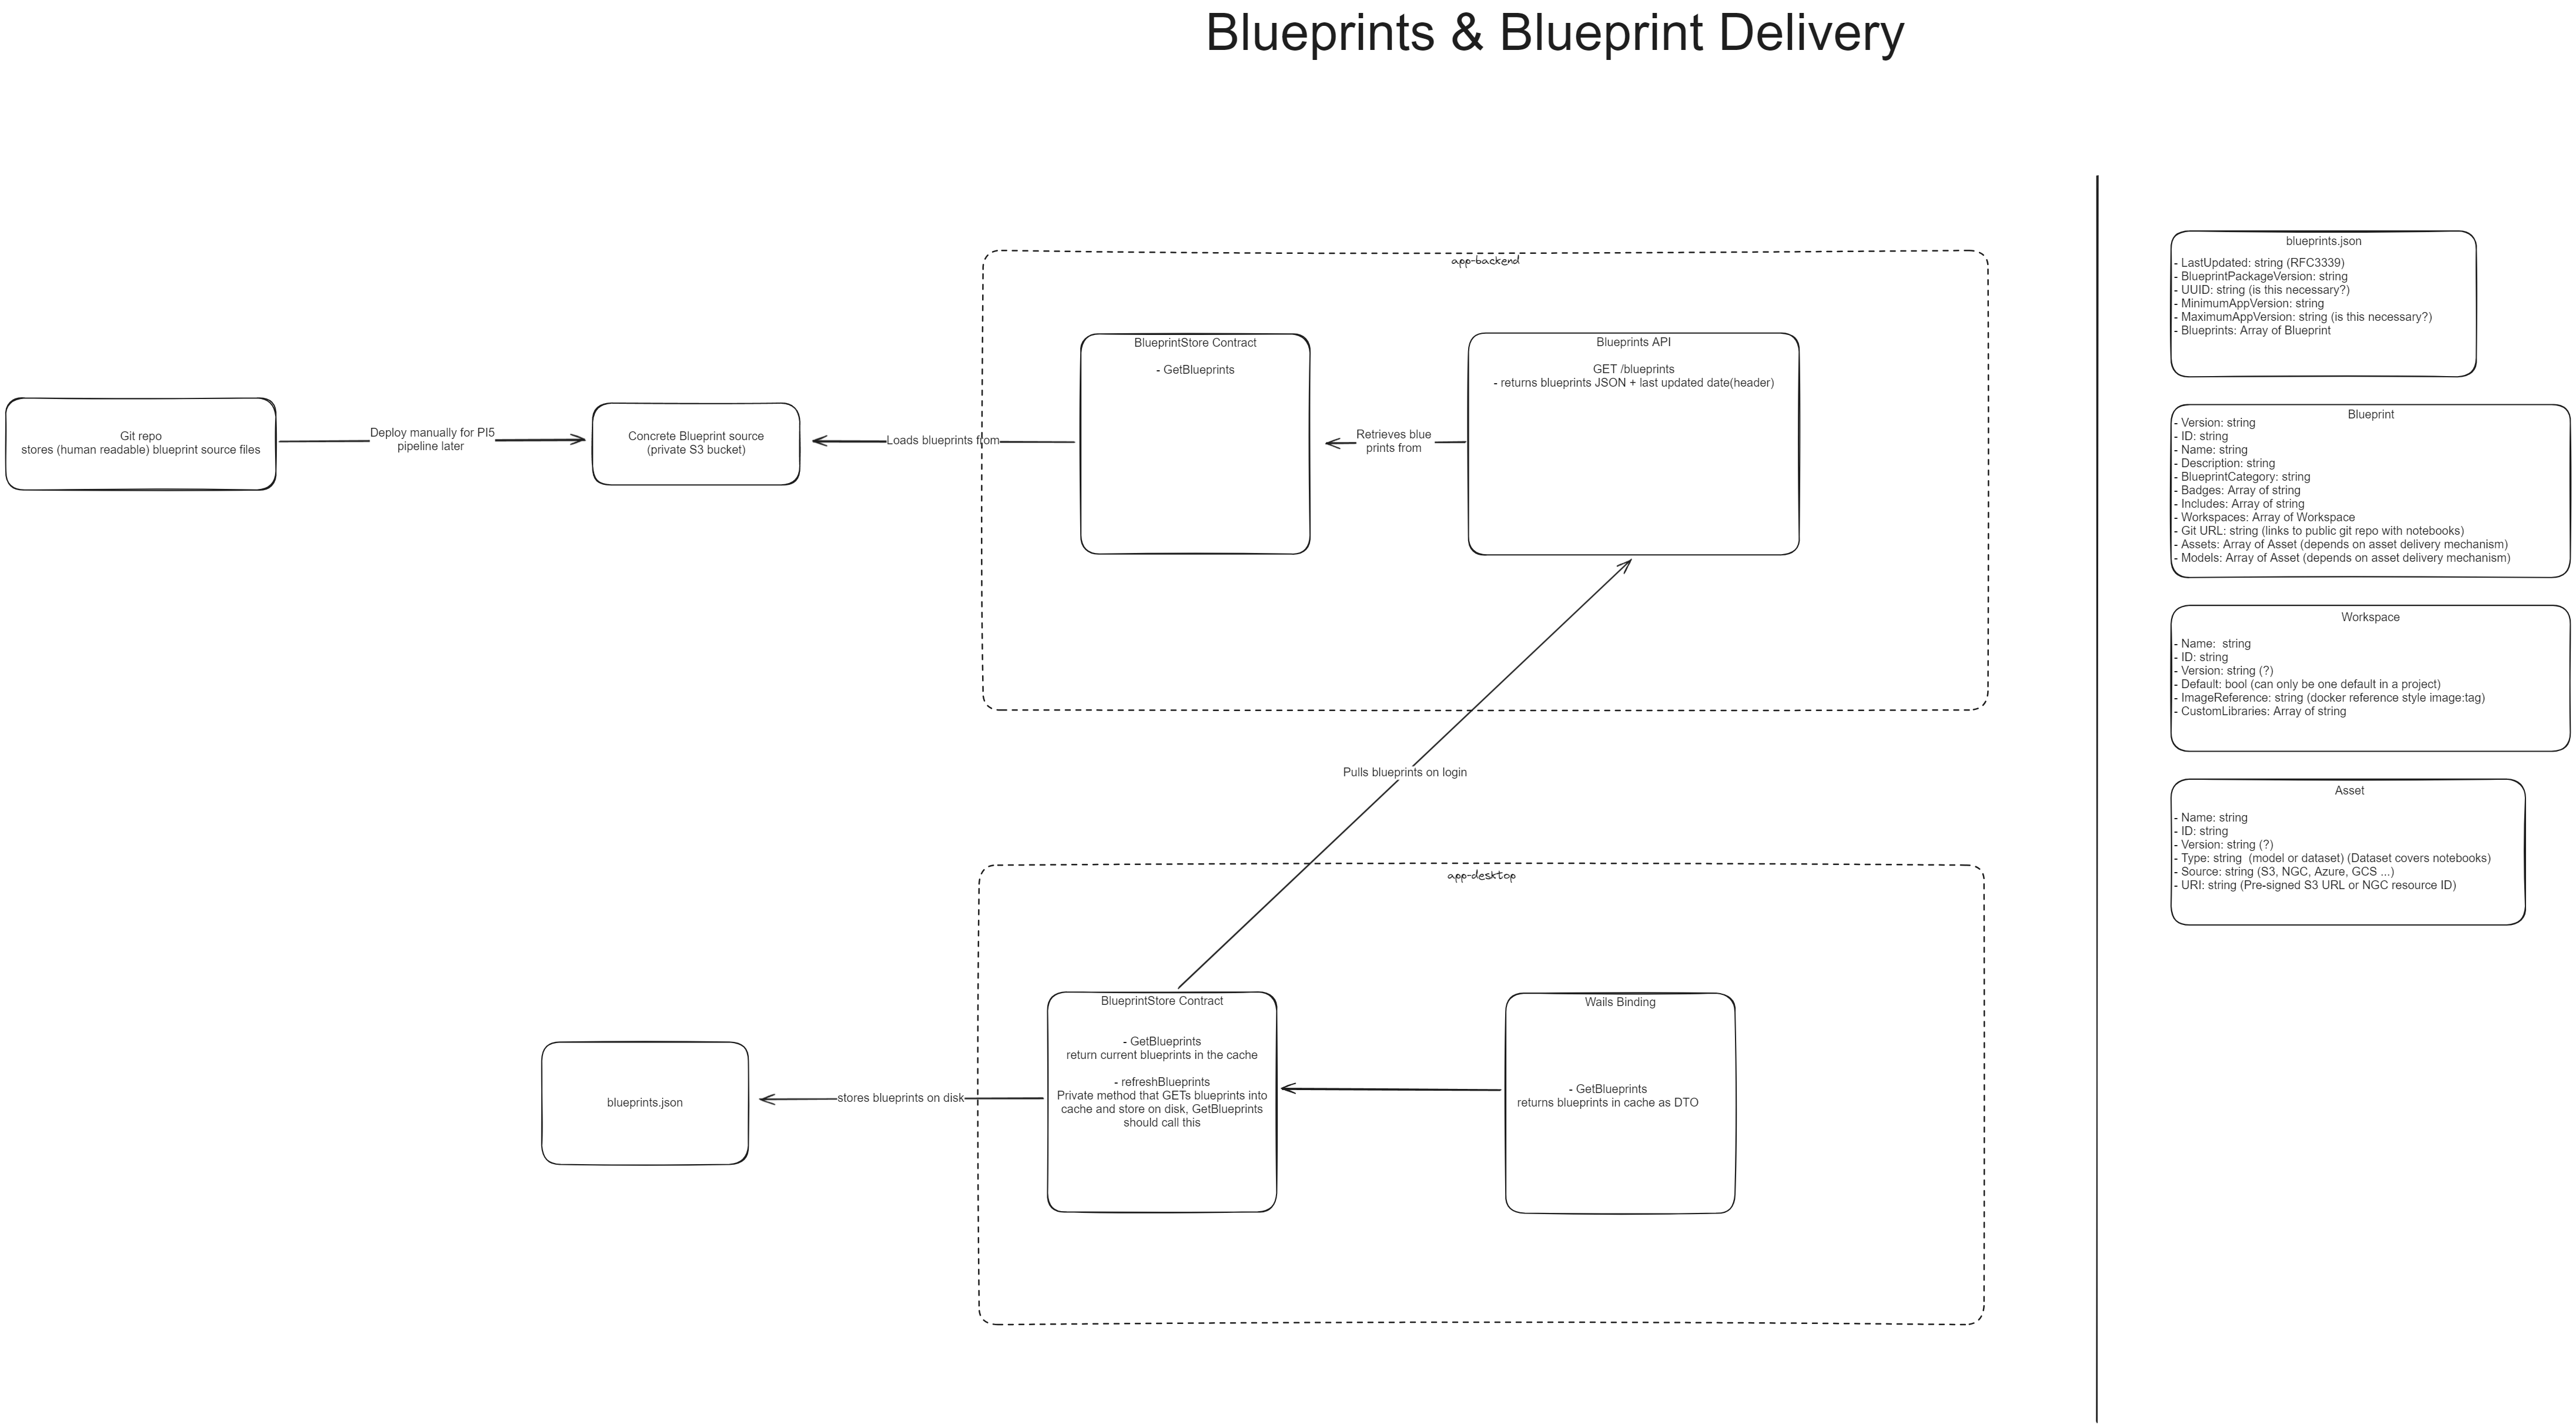

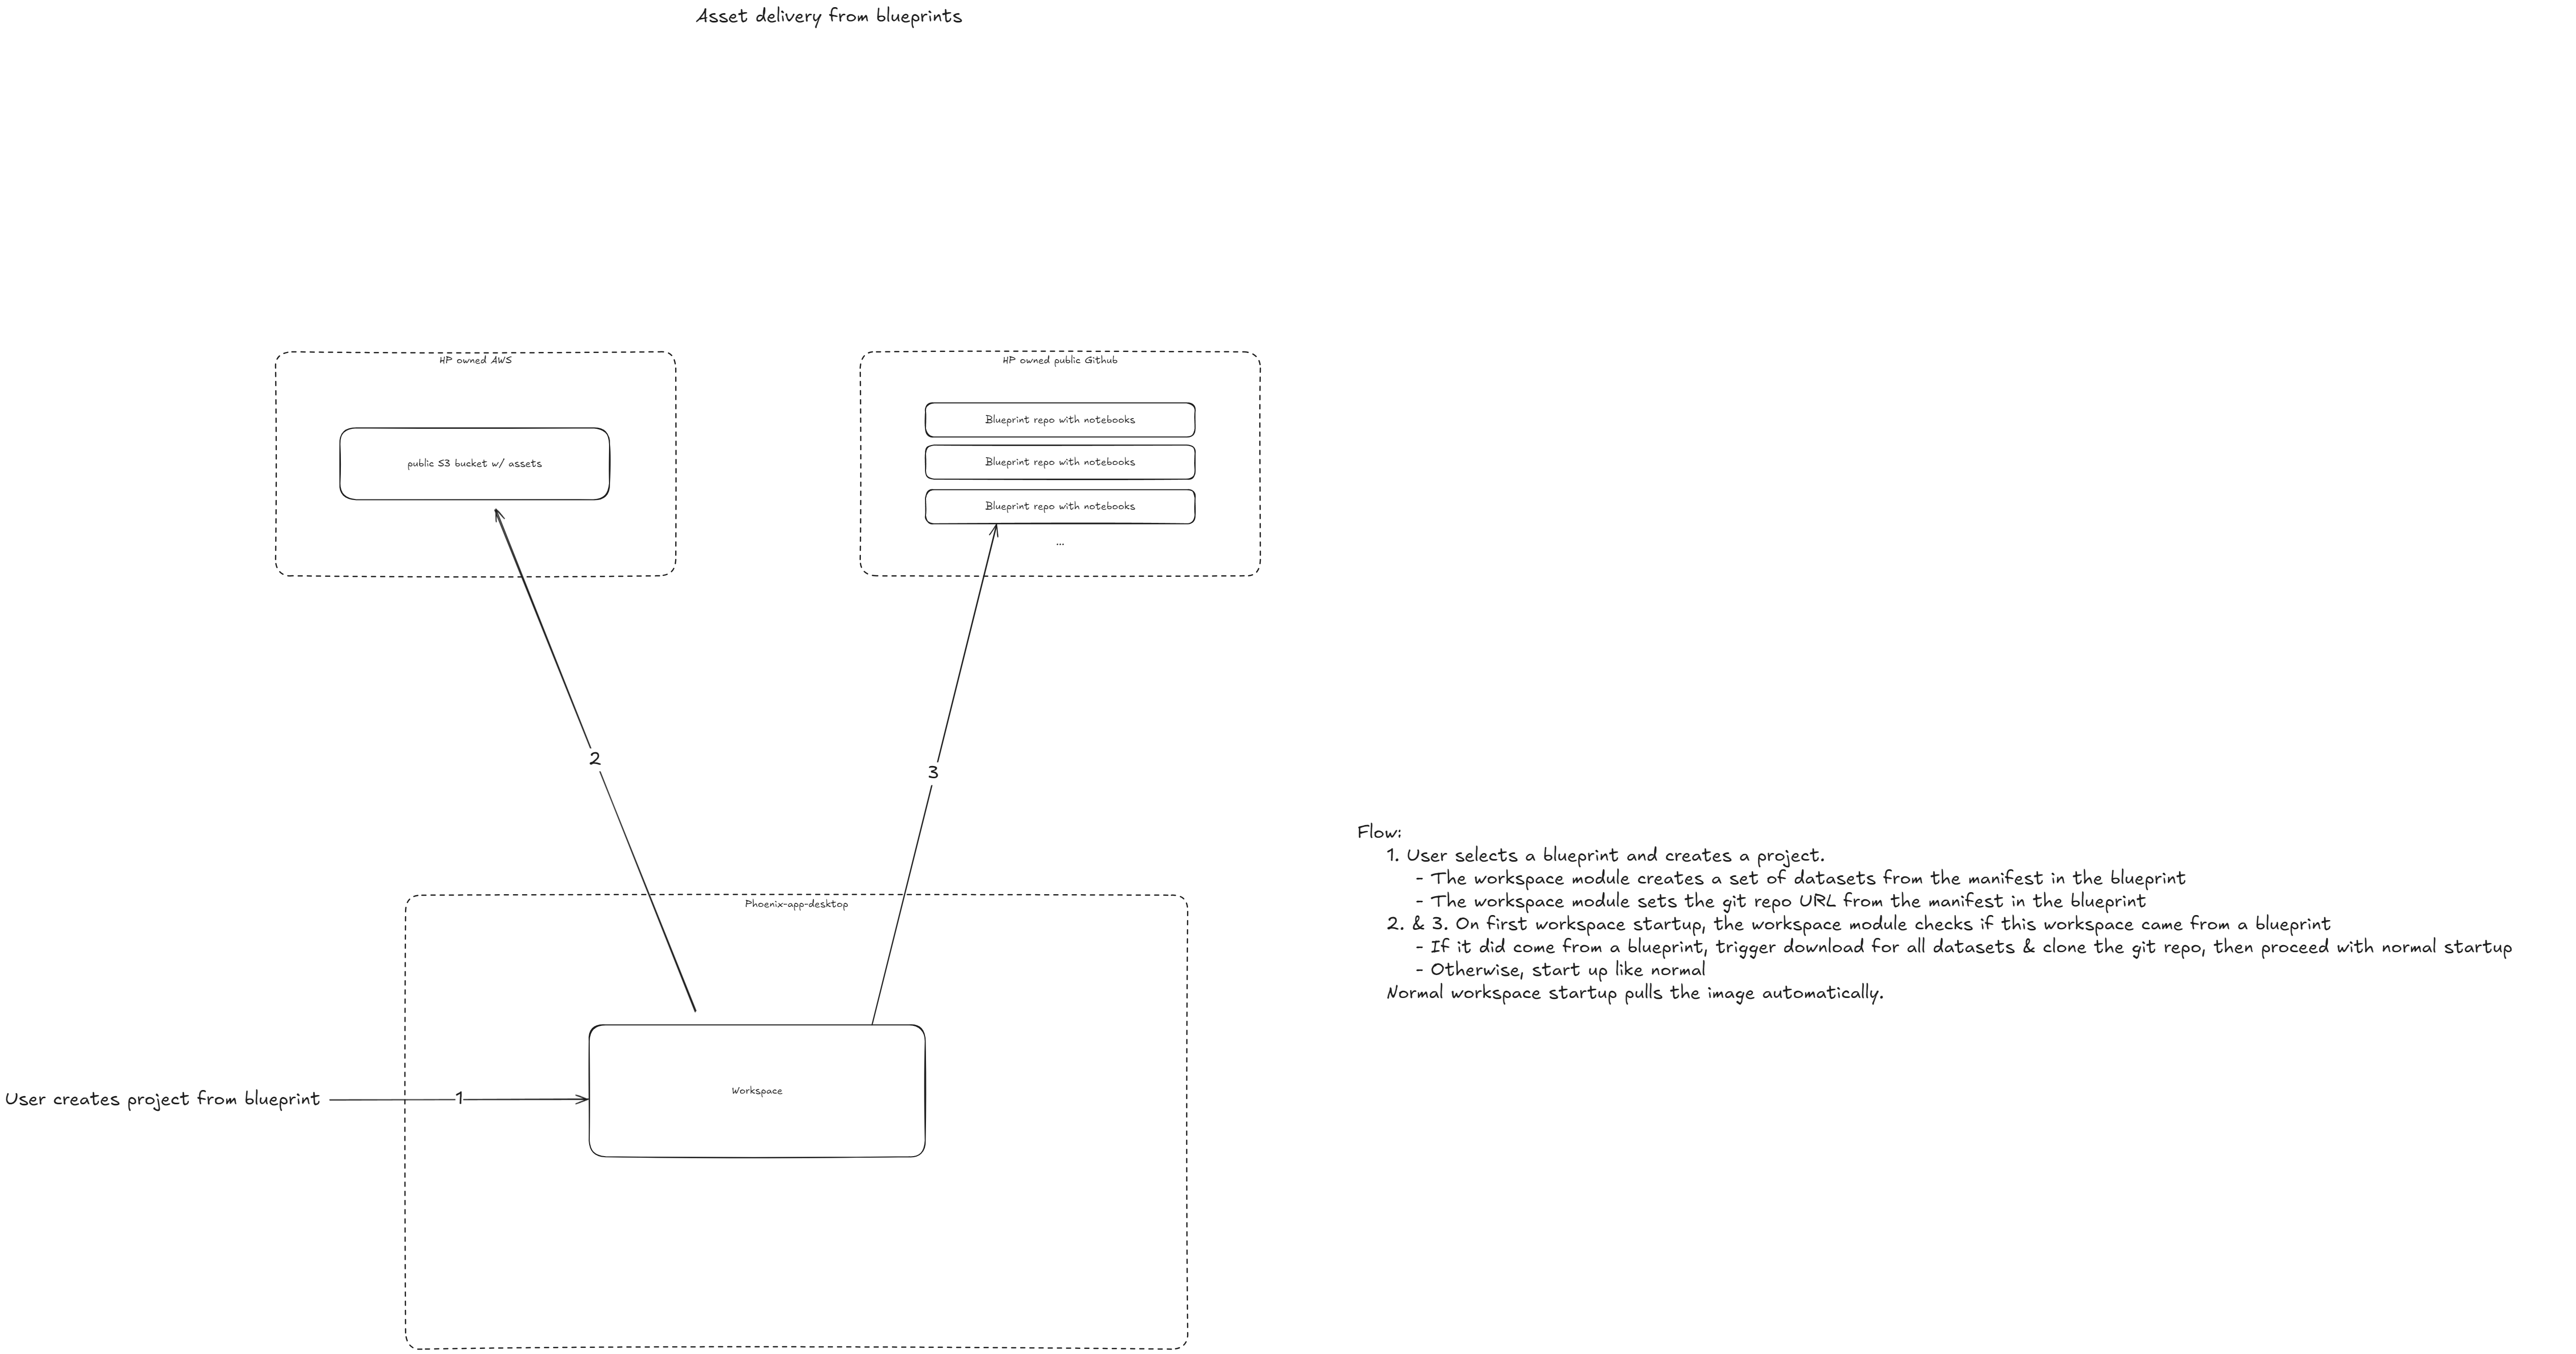

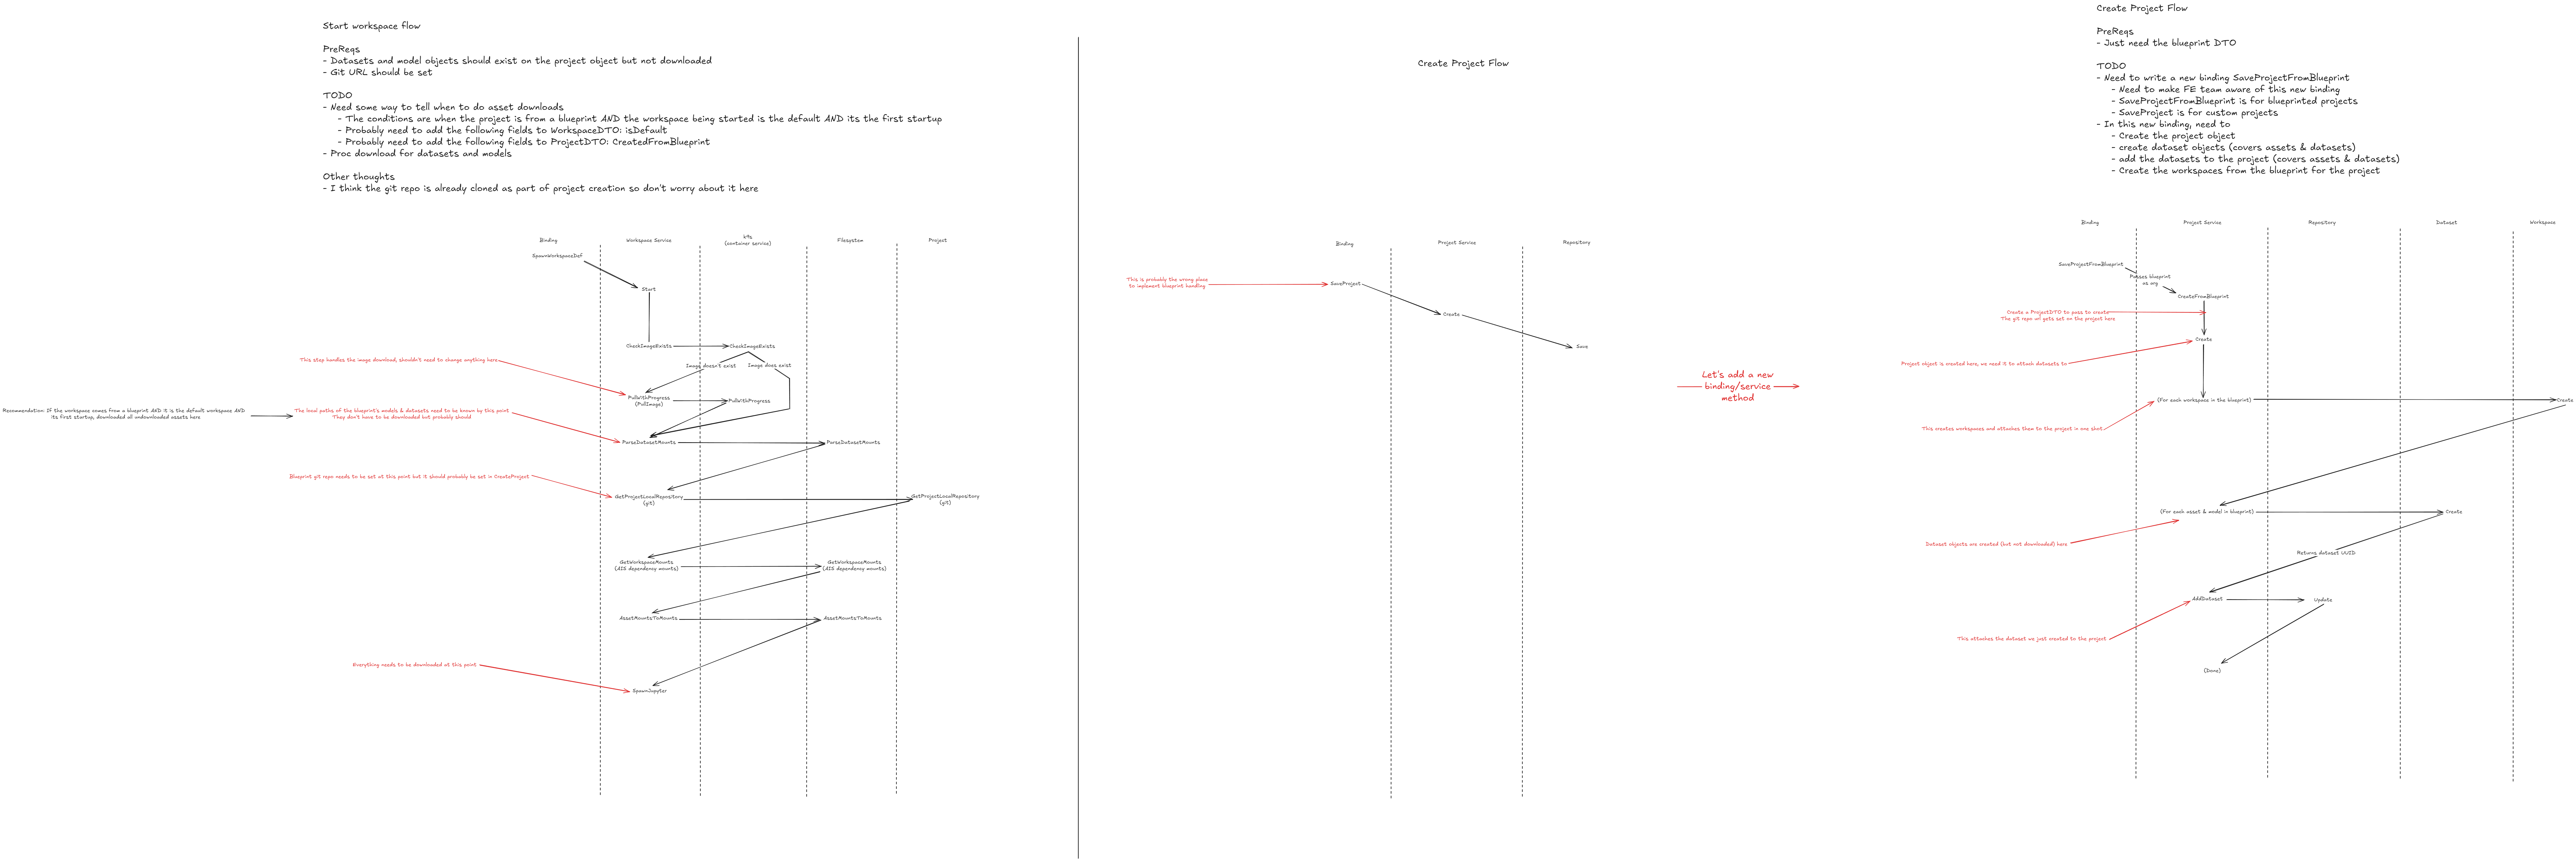

------------------------------------------------------------

2025-07-30 14:28:33 - INFO - Received command: 'query'
2025-07-30 14:28:33 - INFO - CACHE MISS for query: 'What are some feature flags that i can enable in AIStudio?'. Running full pipeline.
------------------------------------------------------------
❓ Query:
What are some feature flags that i can enable in AIStudio?

🤖 Reply:


### Visual Analysis
The user's image is a screenshot of the AIStudio interface, showing various feature flags that can be enabled. The visible flags include "azure", "gcp", and "ngc".

### Synthesized Answer
You can enable several feature flags in AIStudio as shown in the screenshot:

1. **Azure**: Enable this flag to access Azure datasets.
2 GG}
2 306ebea7-00a8.png)
2. **GCP**: Enable this flag for Google Cloud Platform (GCP) datasets.
4. **NGC**: Enable this flag for NVIDIA integration.

These flags are managed using the `hooh` command-line tool, which allows you to add or remove these flags from your configuration file (`features.yaml`). For example:
```bash
$ hooh flags add azure
$ hooh flags add gcp
$ hooh flags add ngc
```

### Source Documents
- [`Development/Feature-Flags/Using-Feature-Flags-in-your-code.md`](#)
- [`How%2Dto-to-articles/How-to-generate-new-feature-flag.md`](#)
- [`Tools/Hooh/ld-command.md`](#)


📊 Faithfulness: 0.8500 | Relevance: 0.8000
⏱️ Generation Time: 11.15s

🖼️ Displaying 2 retrieved image(s):


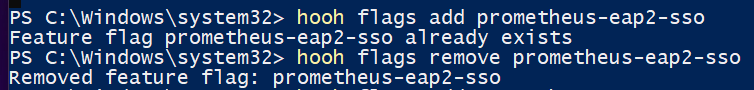

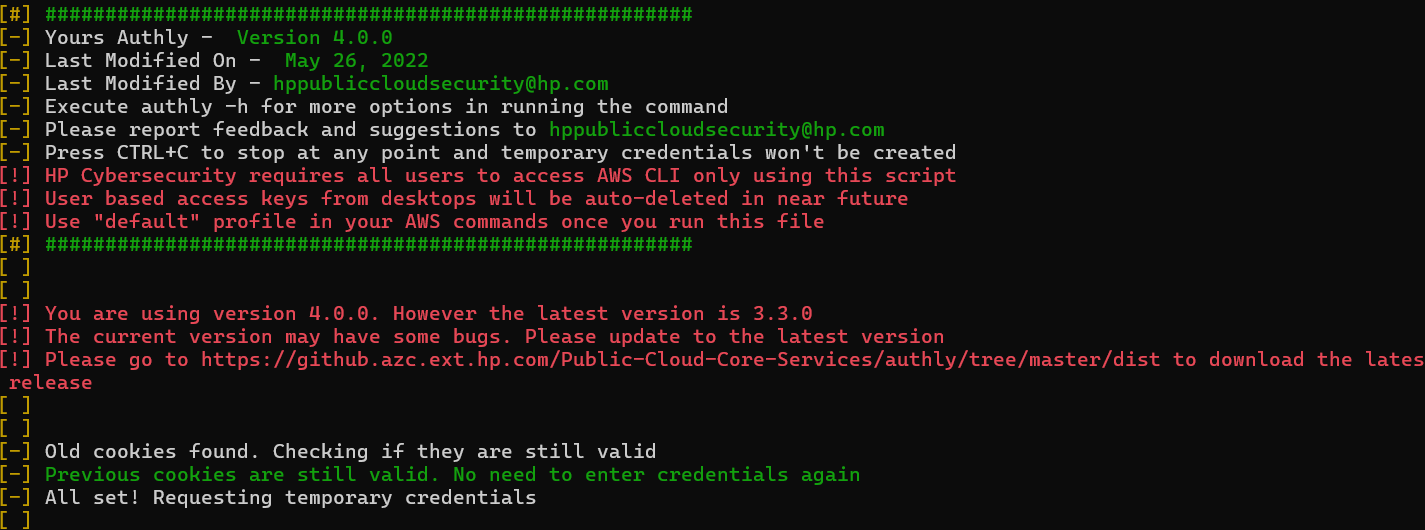

------------------------------------------------------------

2025-07-30 14:28:45 - INFO - Received command: 'query'
2025-07-30 14:28:45 - INFO - CACHE MISS for query: 'How do i manually clean my environment without hooh?'. Running full pipeline.
------------------------------------------------------------
❓ Query:
How do i manually clean my environment without hooh?

🤖 Reply:


### Visual Analysis
The user provided images and text from a document titled "How to manually clean your environment." The images show to the AIStudio directory, showing how to delete specific directories and files. Another image shows of Windows Credentials where credentials can be removed.

### Synthesized Answer
To manually clean your environment using Hooh, follow these steps:

1. **Access the AIStudio Directory:**
   - Open File Explorer.
   - Type `%localappdata%` in the address bar to navigate to the local app data folder.
   - Go to the `HP` directory and then into `AIStudio`.

2 2**Delete Specific Directories and Files:**
   - In the AIStudio directory, remove any directories with an Account ID or those named `db` and `creds`.
   - Delete the `userconfig` file as it stores environment-specific variables.

3. **Remove Windows Credentials:**
   - Search for "Windows Credentials" in the Start menu and open the first result.
   - Select "Windows Credentials" and remove both `hp-aistudio-app` and `hp-aistudio-mongodb`.

These steps ensure that unnecessary data is cleared from your environment when you don't have access to hooh.

### Source Documents
- [`source-file-name.md`](#)


📊 Faithfulness: 0.8500 | Relevance: 0.0000
⏱️ Generation Time: 14.48s

🖼️ Displaying 4 retrieved image(s):


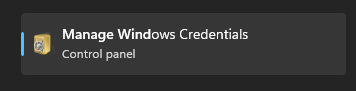

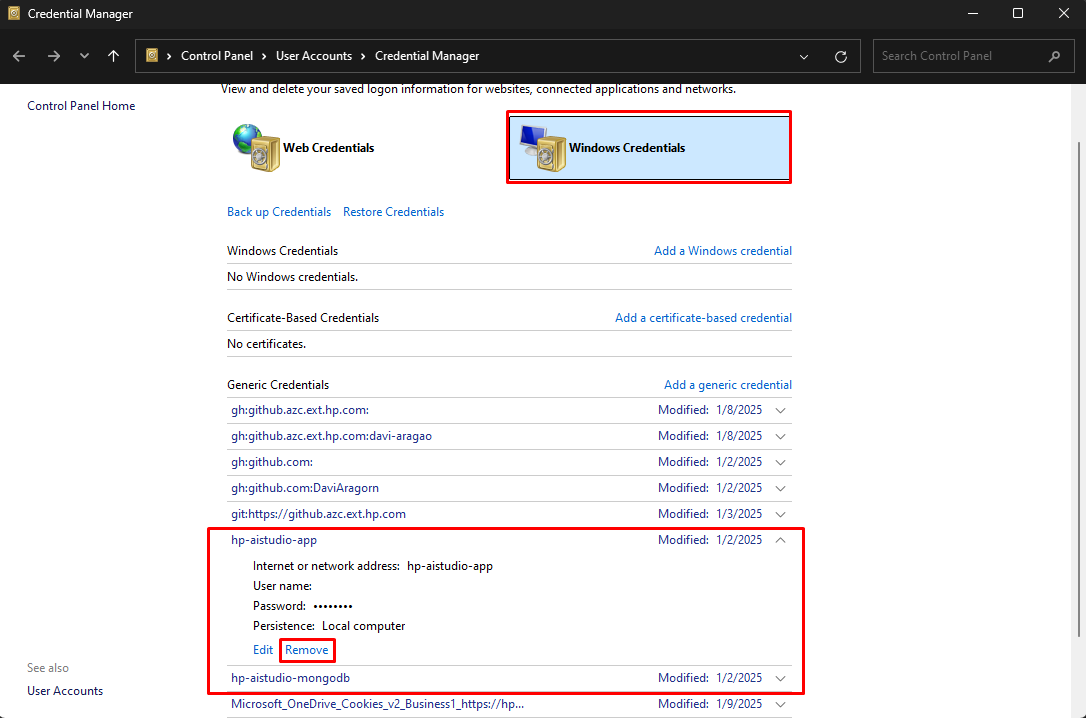

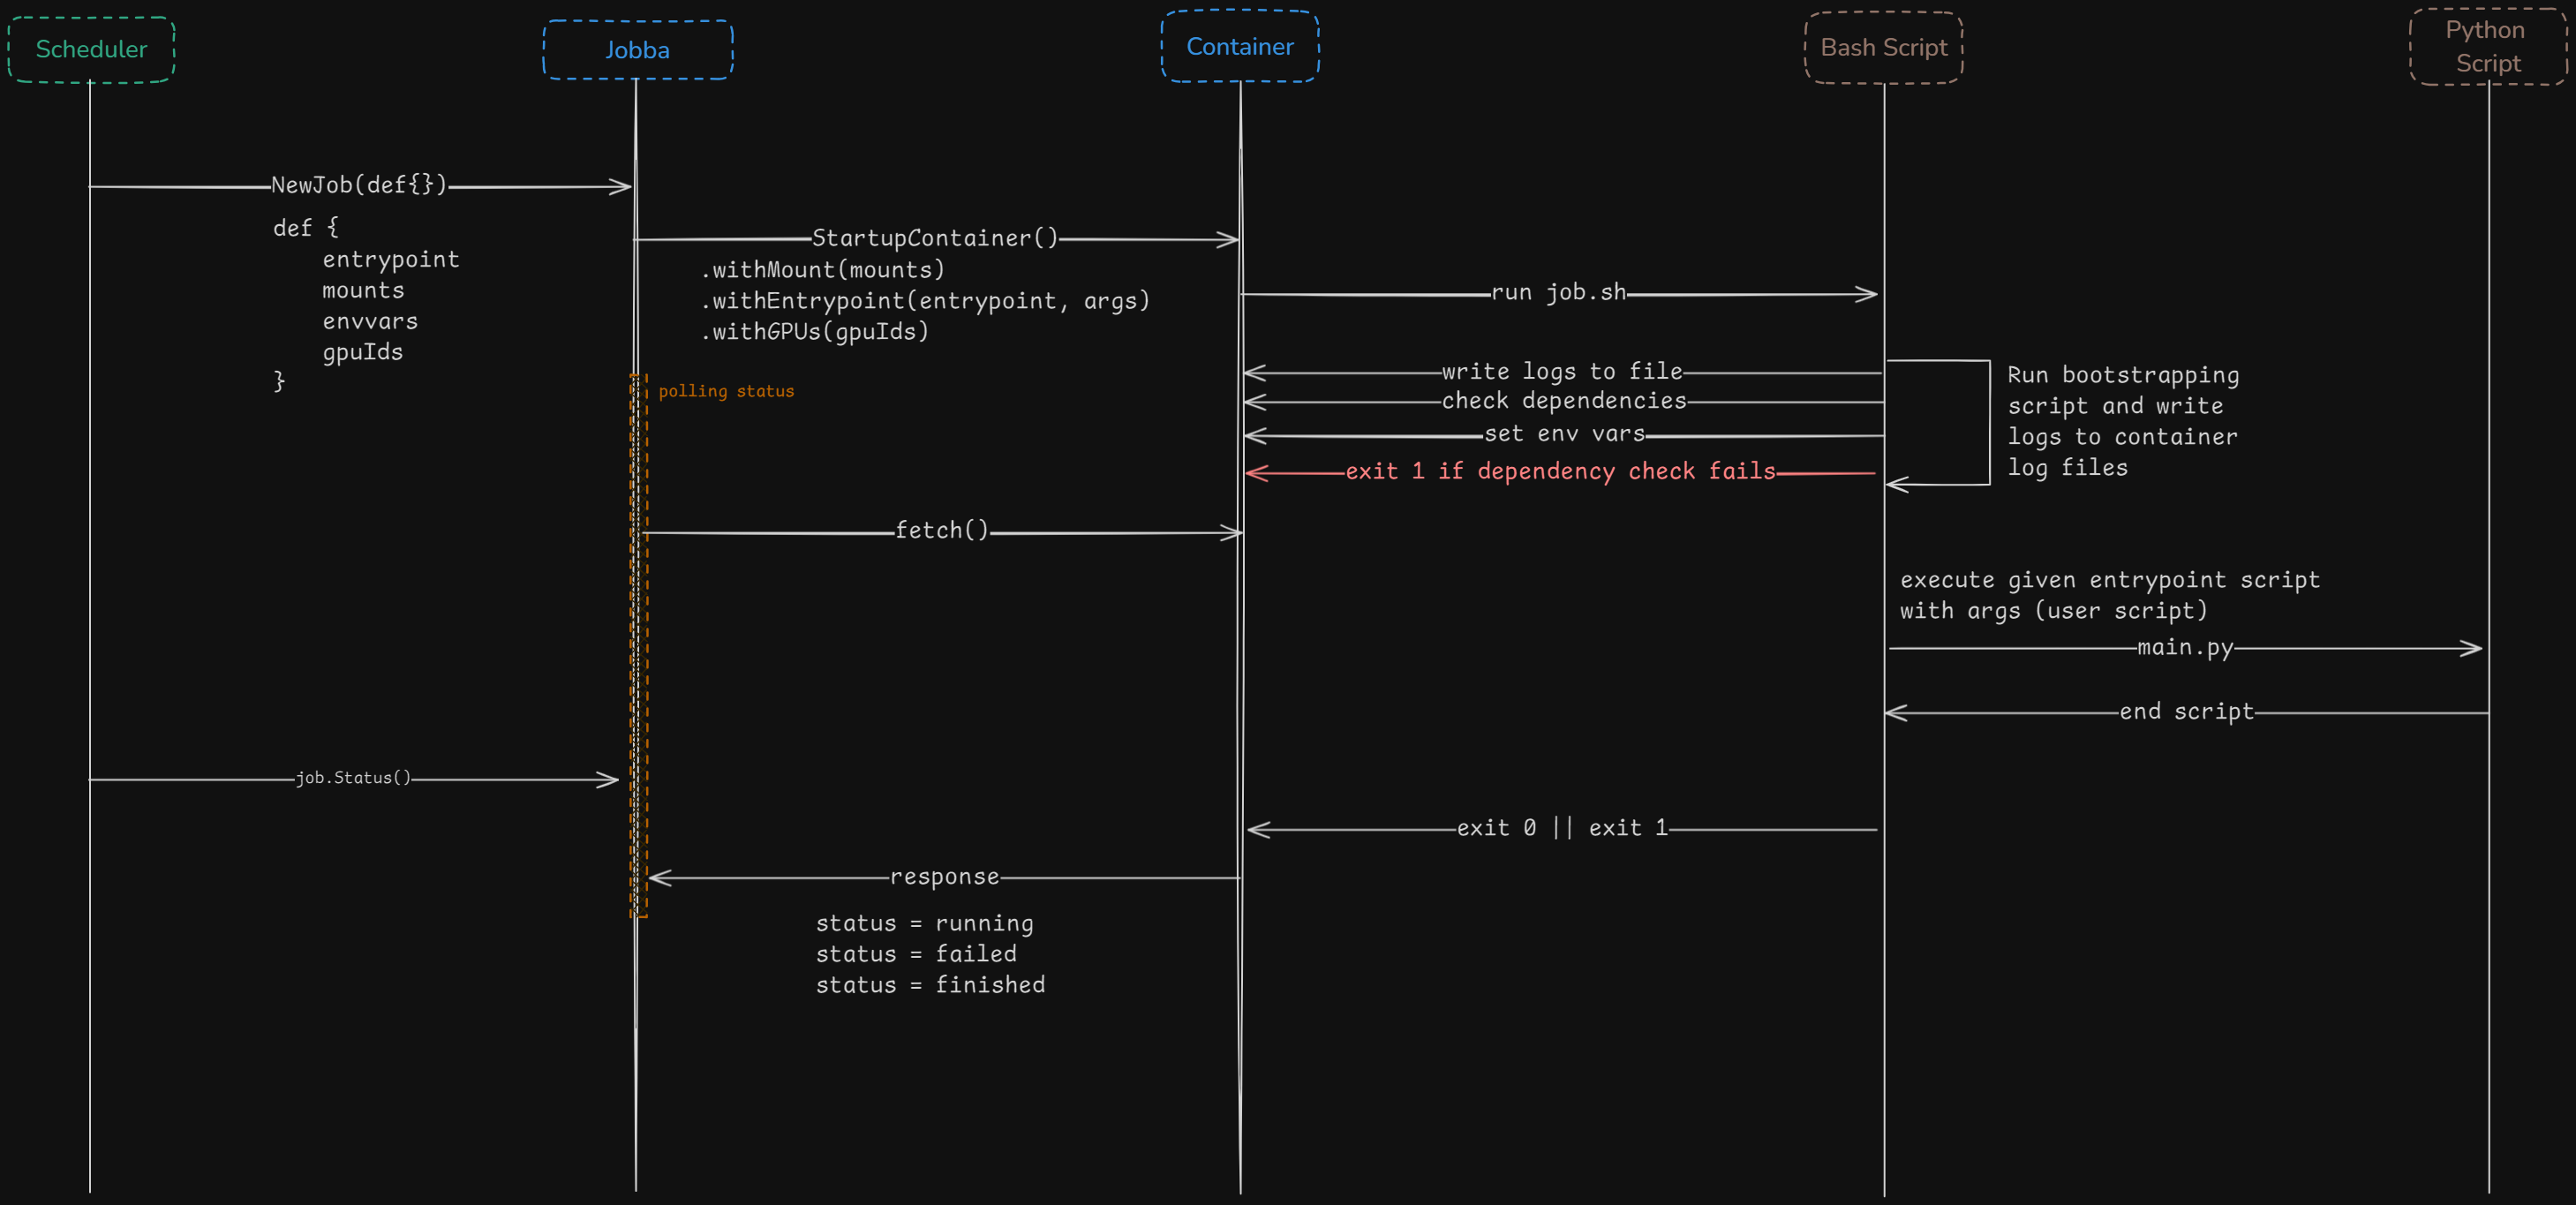

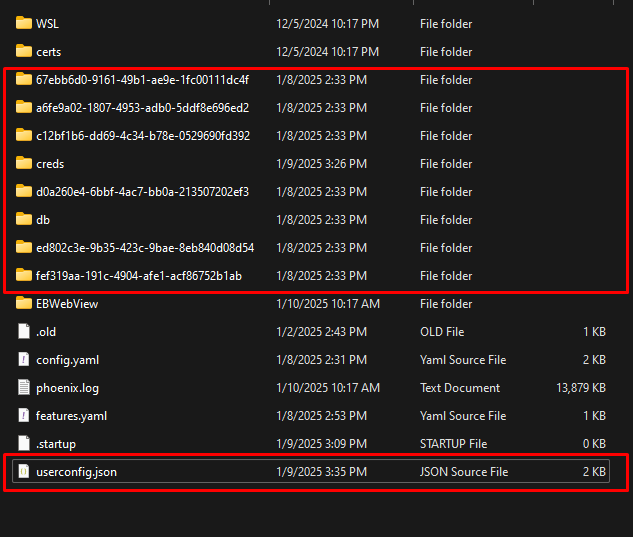

------------------------------------------------------------



In [18]:
if loaded_model:
    logger.info("Running sample inference with the loaded model...")
    
    sample_queries = [
        "What are the AI Blueprints Repository best practices?",
        "What are some feature flags that i can enable in AIStudio?",
        "How do i manually clean my environment without hooh?",
    ]

    for query in sample_queries:
        try:
            # --- CORRECTED LINE ---
            # Add "command": "query" to the input payload to match the new schema.
            input_payload = pd.DataFrame([{
                "command": "query",
                "query": query,
                "force_regenerate": False
            }])
            
            result = loaded_model.predict(input_payload)

            # The display_results function should work without changes
            display_results(query, result)
        except Exception as e:
            logger.error(f"Prediction failed for query '{query}': {e}", exc_info=True)

else:
    logger.warning("Skipping sample inference because the model was not loaded.")

## Step 5: Log Hallucinations & Relevance Evaluations to MlFlow

In [19]:
# In register_model.ipynb, use this as the final cell

# Check if the model was loaded and the original run_id is available
if loaded_model and 'run_id' in locals():
    logger.info(f"--- Reopening original run ({run_id}) to log pre-computed evaluations ---")

    # 1. Define your evaluation dataset with the required 'command'
    evaluation_payload = pd.DataFrame([
        {"command": "query", "query": "What are the AI Blueprints Repository best practices?", "force_regenerate": True},
        {"command": "query", "query": "What are some feature flags that i can enable in AIStudio?", "force_regenerate": True},
        {"command": "query", "query": "How do i manually clean my environment without hooh?", "force_regenerate": True},
    ])

    # 2. Run predict() to get results with the embedded scores
    # This assumes the knowledge base has already been updated in a previous step
    results_df = loaded_model.predict(evaluation_payload)
    
    # Add the original query to the results for clarity in the logged table
    results_df['query'] = evaluation_payload['query']

    # 3. Reopen the existing run using its ID
    with mlflow.start_run(run_id=run_id) as run:
        logger.info("Successfully reopened existing run. Logging metrics and artifacts...")

        # 4. Calculate average scores from the DataFrame
        # Use .astype(float) to handle potential None values gracefully
        avg_faithfulness = results_df["faithfulness"].astype(float).mean()
        avg_relevance = results_df["relevance"].astype(float).mean()

        # 5. Log the average scores as metrics to the original run
        mlflow.log_metrics({
            "avg_faithfulness": avg_faithfulness,
            "avg_relevance": avg_relevance
        })

        # 6. Log the full results DataFrame as a table artifact to the original run
        mlflow.log_table(data=results_df, artifact_file="inline_evaluation_results.json")
        
        logger.info("✅ Successfully logged metrics and artifacts to the original model run.")

else:
    logger.warning("Skipping logging because the model was not loaded or run_id was not found.")

2025-07-30 14:29:01 - INFO - --- Reopening original run (888b8baab0034ddc9cb752ce02913759) to log pre-computed evaluations ---
2025-07-30 14:29:01 - INFO - Received command: 'query'
2025-07-30 14:29:01 - INFO - Forced regeneration for query: 'What are the AI Blueprints Repository best practices?'. Clearing old cache entry.
2025-07-30 14:29:01 - INFO - CACHE MISS for query: 'What are the AI Blueprints Repository best practices?'. Running full pipeline.
2025-07-30 14:29:21 - INFO - Successfully reopened existing run. Logging metrics and artifacts...
2025-07-30 14:29:22 - INFO - ✅ Successfully logged metrics and artifacts to the original model run.


In [20]:
end_time: float = time.time()
elapsed_time: float = end_time - start_time
elapsed_minutes: int = int(elapsed_time // 60)
elapsed_seconds: float = elapsed_time % 60

logger.info(f"⏱️ Total execution time: {elapsed_minutes}m {elapsed_seconds:.2f}s")
logger.info("✅ Notebook execution completed.")

2025-07-30 14:29:22 - INFO - ⏱️ Total execution time: 13m 20.30s
2025-07-30 14:29:22 - INFO - ✅ Notebook execution completed.


Built with ❤️ using Z by HP AI Studio.